In [ ]:
!pip install -Uqq tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive


drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
dataset_path = '/gdrive/My Drive/AI/datasets/WISDM_ar_v1.1_raw.txt'

In [ ]:
# raw.txt follows this format:
# [user],[activity],[timestamp],[x-acceleration],[y-accel],[z-accel];

df = pd.DataFrame(
    pd.read_csv(dataset_path,
                sep=',',
                lineterminator=';',
                on_bad_lines='skip',
                names=['user', 'activity', 'timestamp', 'x-acceleration', 'y-acceleration', 'z-acceleration']
))

df.drop(['user'], axis=1, inplace=True)

# remove last bugged line
df.drop(df.tail(1).index, inplace=True)

df['magnitude'] = np.sqrt(df['x-acceleration']**2 + df['y-acceleration']**2 + df['z-acceleration']**2)

df

<ipython-input-3-12342b081e44>:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(dataset_path,


,activity,timestamp,x-acceleration,y-acceleration,z-acceleration,magnitude
0,Jogging,4.910596e+13,-0.694638,12.680544,0.503953,12.709551
1,Jogging,4.910606e+13,5.012288,11.264028,0.953424,12.365693
2,Jogging,4.910611e+13,4.903325,10.882658,-0.081722,11.936562
3,Jogging,4.910622e+13,-0.612916,18.496431,3.023717,18.751973
4,Jogging,4.910633e+13,-1.184970,12.108489,7.205164,14.139804
...,...,...,...,...,...,...
1086469,Sitting,1.316233e+14,9.000000,-1.570000,1.690000,9.290910
1086470,Sitting,1.316234e+14,9.040000,-1.460000,1.730000,9.319125
1086471,Sitting,1.316234e+14,9.080000,-1.380000,1.690000,9.338463
1086472,Sitting,1.316235e+14,9.000000,-1.460000,1.730000,9.280329


In [ ]:
N_TIME_STEPS = 200
N_FEATURES = 4
step = 40
segments = []
labels = []

for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-acceleration'].values[i: i + N_TIME_STEPS]
    ys = df['y-acceleration'].values[i: i + N_TIME_STEPS]
    zs = df['z-acceleration'].values[i: i + N_TIME_STEPS]
    mg = df['magnitude'].values[i: i + N_TIME_STEPS]

    # Segmento no formato (200, 4)
    segment = np.array([xs, ys, zs, mg]).T
    segments.append(segment)

    # Atividade predominante (label mais comum na janela)
    window_activities = df['activity'][i: i + N_TIME_STEPS]
    values, counts = np.unique(window_activities, return_counts=True)
    label = values[np.argmax(counts)]
    labels.append(label)

# Converter listas para arrays
segments = np.asarray(segments, dtype=np.float32)  # shape: (n, 200, 3)

# One-hot encoding
labels = pd.get_dummies(labels)                    # DataFrame com colunas = classes
labels = np.asarray(labels, dtype=np.float32)      # shape: (n, n_classes)

In [ ]:
print(segments.shape, labels, pd.get_dummies(np.unique(df['activity'])), sep='\n')

(27157, 200, 4)
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
   Downstairs  Jogging  Sitting  Standing  Upstairs  Walking
0        True    False    False     False     False    False
1       False     True    False     False     False    False
2       False    False     True     False     False    False
3       False    False    False      True     False    False
4       False    False    False     False      True    False
5       False    False    False     False     False     True


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    segments, labels, test_size=0.4, random_state=42, stratify=labels)

In [ ]:
# creates model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(200,4), unroll=True))
model.add(tf.keras.layers.LSTM(64, unroll=True))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(6, activation='softmax'))


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# use gpu to fit it
with tf.device('/device:GPU:0'):
  model.fit(x_train, y_train, epochs=50, batch_size=512)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.4638 - loss: 1.4563
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7215 - loss: 0.8617
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7357 - loss: 0.7728
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7625 - loss: 0.7114
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7902 - loss: 0.6117
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7743 - loss: 0.6338
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8085 - loss: 0.5378
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8103 - loss: 0.5079
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8306 - loss: 0.4668
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8218 - loss: 0.4987
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8294 - loss: 0.4618
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy:

In [ ]:
# Comentado para evitar acidentes de sobrescrita
# model.save('/gdrive/My Drive/AI/WISDM_model.keras')

In [ ]:
model = tf.keras.models.load_model('/gdrive/My Drive/AI/model.keras')

ValueError: File not found: filepath=/gdrive/My Drive/AI/model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
model.evaluate(x_test, y_test, batch_size=128)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9727 - loss: 0.0880


[0.0874025896191597, 0.9727515578269958]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Enabling resource variables doesn't fully resolve the issue with dynamic shapes in LSTM

# Use Select TF ops and disable the experimental lowering of tensor list ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS  # Include TFLite built-in operations
]

converter.experimental_enable_resource_variables = True

# force *lowering* of all TensorList ops into TFLITE_BUILTINS
converter._experimental_lower_tensor_list_ops = True

tflite_model = converter.convert()

Saved artifact at '/tmp/tmporx5vvpz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138240567257296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138240567255952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138240567256144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138240567252688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138240567253264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138240567251920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138240567255184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138240567250768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138240545279248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138240545281168: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
with open('/gdrive/My Drive/AI/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="/gdrive/My Drive/AI/WISDM_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# prompt: evaluate precision of tflite_model

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Prepare the test data for TFLite inference
x_test_tflite = x_test.astype(np.float32)

# Run inference on the TFLite model
tflite_predictions = []
for i in range(len(x_test_tflite)):
    input_data = np.expand_dims(x_test_tflite[i], axis=0)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    tflite_predictions.append(output_data[0])

# Convert TFLite predictions to class labels
tflite_predicted_classes = np.argmax(np.array(tflite_predictions), axis=1)

# Get the true class labels from y_test
true_classes = np.argmax(y_test, axis=1)

# Evaluate precision, recall, and F1-score
precision = precision_score(true_classes, tflite_predicted_classes, average='weighted')
recall = recall_score(true_classes, tflite_predicted_classes, average='weighted')
f1 = f1_score(true_classes, tflite_predicted_classes, average='weighted')

print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")

Precision (weighted): 0.9770
Recall (weighted): 0.9767
F1-score (weighted): 0.9768


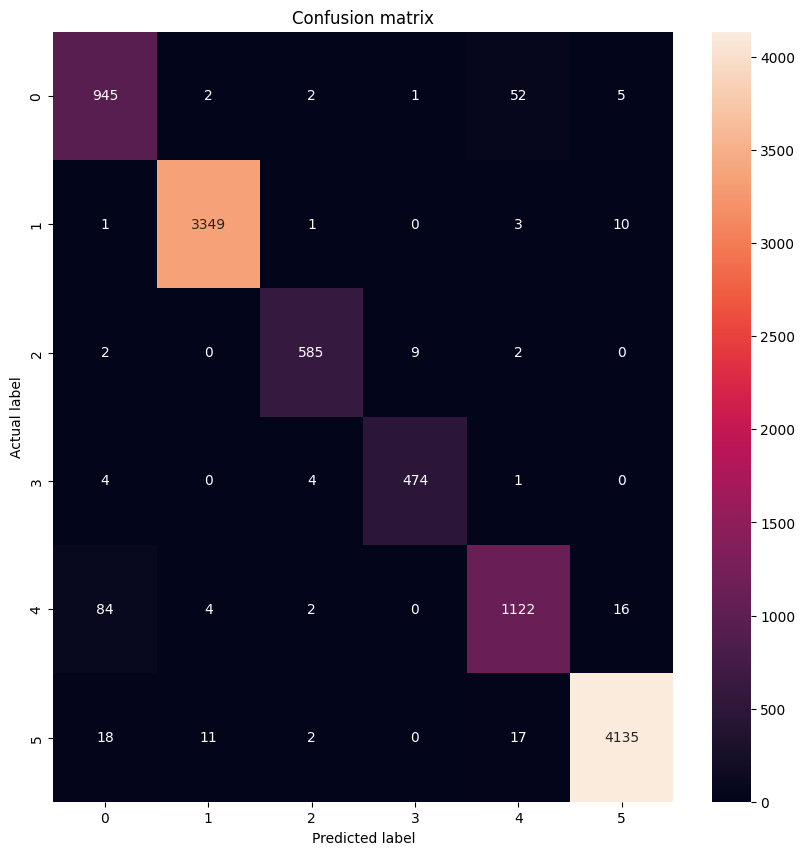

In [ ]:
#plot the confusion matrix
import seaborn as sns

cm = confusion_matrix(true_classes, tflite_predicted_classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# find walking or downstairs or upstairs in df
df[df['activity'].isin(['Walking', 'Downstairs', 'Upstairs'])]

,activity,timestamp,x-acceleration,y-acceleration,z-acceleration,magnitude
597,Walking,4.939499e+13,0.844462,8.008764,2.792171,8.523476
598,Walking,4.939510e+13,1.116869,8.621680,3.786457,9.482511
599,Walking,4.939520e+13,-0.503953,16.657684,1.307553,16.716522
600,Walking,4.939530e+13,4.794363,10.760075,-1.184970,11.839311
601,Walking,4.939541e+13,-0.040861,9.234595,-0.694638,9.260774
...,...,...,...,...,...,...
1081803,Downstairs,1.313572e+14,-4.140000,7.930000,2.750000,9.358793
1081804,Downstairs,1.313572e+14,-7.010000,9.430000,0.910000,11.785292
1081805,Downstairs,1.313572e+14,-8.850000,14.330000,0.300000,16.845219
1081806,Downstairs,1.313573e+14,-7.590000,8.310000,-2.760000,11.588002


from matplotlib import pyplot as plt
_df_0['timestamp'].plot(kind='hist', bins=20, title='timestamp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['x-acceleration'].plot(kind='hist', bins=20, title='x-acceleration')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['y-acceleration'].plot(kind='hist', bins=20, title='y-acceleration')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['z-acceleration'].plot(kind='hist', bins=20, title='z-acceleration')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('activity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='timestamp', y='x-acceleration', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='x-acceleration', y='y-acceleration', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='y-acceleration', y='z-acceleration', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='z-acceleration', y='magnitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['x-acceleration']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('activity')):
  _plot_series(series, series_name, i)
  fig.legend(title='activity', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('x-acceleration')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['y-acceleration']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('activity')):
  _plot_series(series, series_name, i)
  fig.legend(title='activity', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('y-acceleration')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['z-acceleration']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('activity')):
  _plot_series(series, series_name, i)
  fig.legend(title='activity', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('z-acceleration')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['magnitude']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('activity')):
  _plot_series(series, series_name, i)
  fig.legend(title='activity', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('magnitude')

from matplotlib import pyplot as plt
_df_13['timestamp'].plot(kind='line', figsize=(8, 4), title='timestamp')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['x-acceleration'].plot(kind='line', figsize=(8, 4), title='x-acceleration')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['y-acceleration'].plot(kind='line', figsize=(8, 4), title='y-acceleration')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['z-acceleration'].plot(kind='line', figsize=(8, 4), title='z-acceleration')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['activity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='timestamp', y='activity', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['activity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='x-acceleration', y='activity', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['activity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='y-acceleration', y='activity', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['activity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='z-acceleration', y='activity', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-45-e0a4807672ce>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='x-acceleration', y='activity', inner='box', palette='Dark2')
<ipython-input-45-e0a4807672ce>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='y-acceleration', y='activity', inner='box', palette='Dark2')
<ipython-input-45-e0a4807672ce>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='z-acceleration', y='activity', inner='box', palette='Dark2')


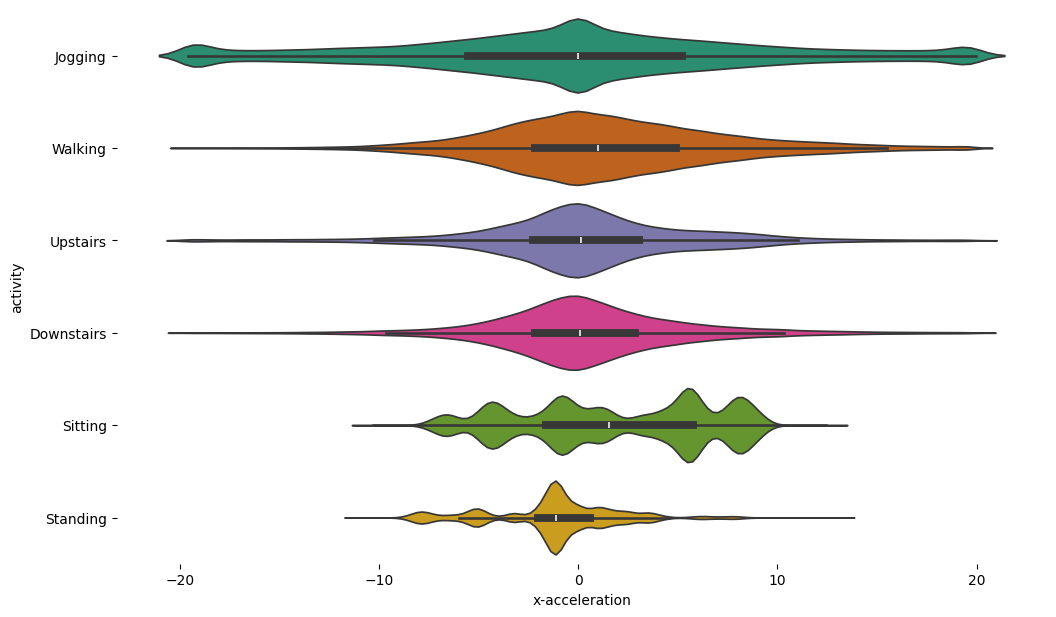

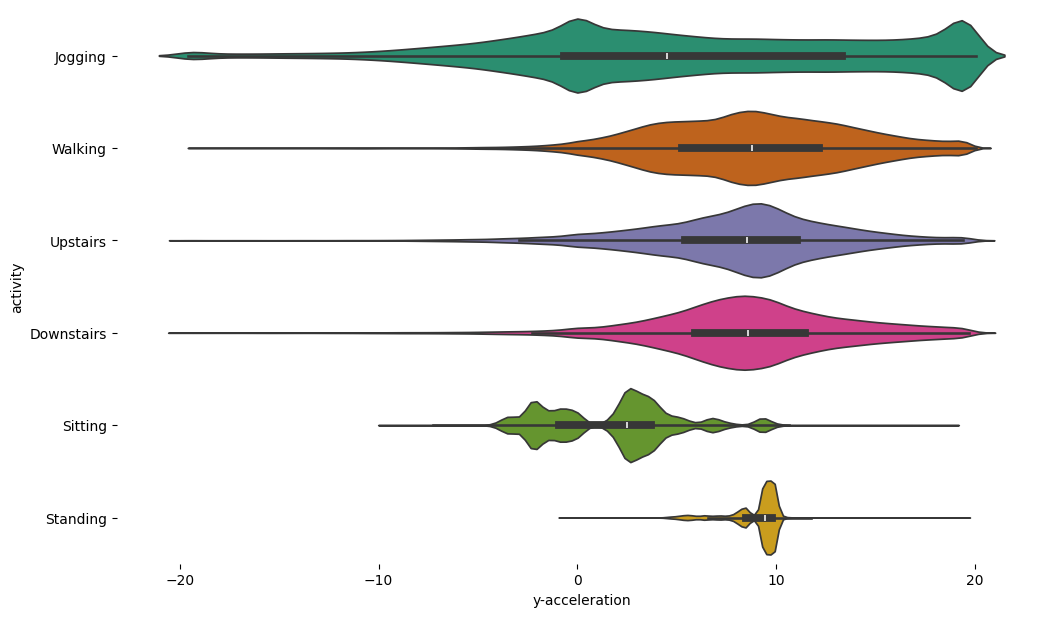

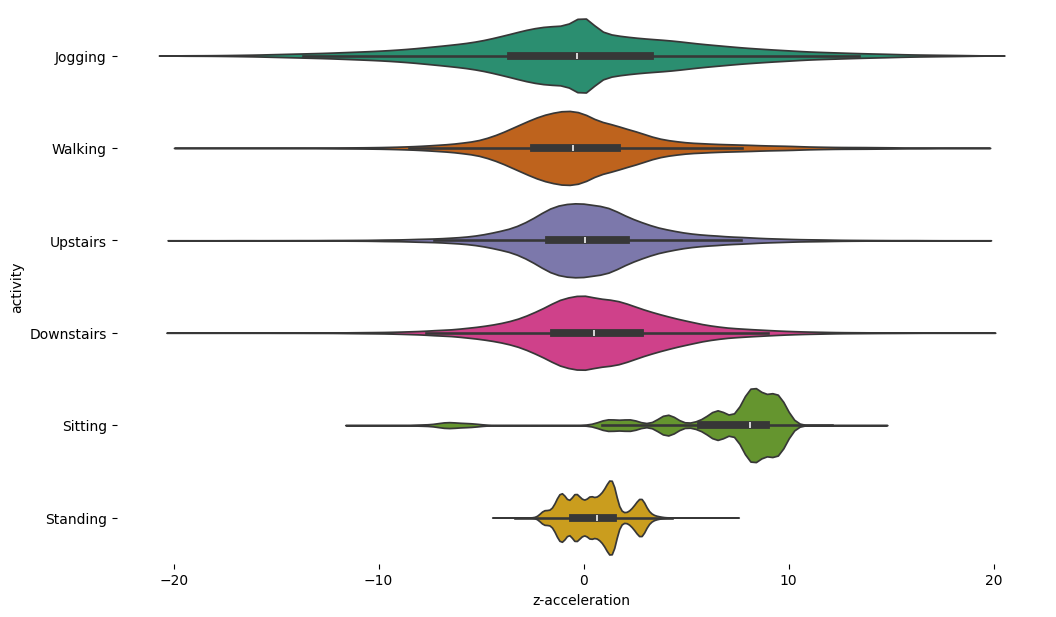

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['activity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='x-acceleration', y='activity', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['activity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='y-acceleration', y='activity', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['activity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='z-acceleration', y='activity', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)